D'après une étude VIF, il faudrait supprimer les colonnes ZipCode, Latitude, Longitude

In [20]:
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn import model_selection

import math
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV

# Preprocessing

In [2]:
df = pd.read_csv("data_cleaned.csv")
df.drop(['ZipCode','Latitude', 'Longitude'], axis=1, inplace=True)

In [3]:
X = df.drop('TotalGHGEmissions', axis=1)
y = df['TotalGHGEmissions']

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y,test_size=0.3)

In [5]:
imputer = KNNImputer(n_neighbors=5)
imputer = imputer.fit(X_train[["ENERGYSTARScore"]])
X_train[["ENERGYSTARScore"]] = imputer.transform(X_train[["ENERGYSTARScore"]])
X_test[["ENERGYSTARScore"]] = imputer.transform(X_test[["ENERGYSTARScore"]])

In [6]:
# MinMaxScaler
rs = MinMaxScaler()
rs = rs.fit(X_train[['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge']])
X_train[['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge']] = rs.transform(X_train[['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge']])
X_test[['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge']] = rs.transform(X_test[['CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'SteamUse(kBtu)', 'BuildingAge']])

In [ ]:
# OneHotEncoder
ohe = OneHotEncoder(sparse=False)
OH_cols_train = pd.DataFrame(ohe.fit_transform(X_train[['BuildingType', 'PrimaryPropertyType', 'Neighborhood']]), columns=ohe.get_feature_names())
OH_cols_test = pd.DataFrame(ohe.transform(X_test[['BuildingType', 'PrimaryPropertyType', 'Neighborhood']]), columns=ohe.get_feature_names())

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index


num_trainset = X_train.drop(columns={'BuildingType', 'PrimaryPropertyType', 'Neighborhood'}, axis = 1)
num_testset = X_test.drop(columns={'BuildingType', 'PrimaryPropertyType', 'Neighborhood'}, axis = 1)

# Add one-hot encoded columns to numerical features
OH_trainset = pd.concat([num_trainset, OH_cols_train], axis=1)
OH_testset = pd.concat([num_testset, OH_cols_test], axis=1)

X_train = OH_trainset
X_test = OH_testset

# Modélisation

In [26]:
results = pd.DataFrame(columns=['Modèle','RMSE','Inference_duration (microsecs)'])

# RandomForest Regressor

In [21]:
parameters = {
    'n_estimators' : [10,50,100,300,500],
    'min_samples_leaf' : [1,3,5,10], 
    'max_features': ['auto', 'sqrt']
}

In [22]:
rfr = GridSearchCV(RandomForestRegressor(), param_grid = parameters, verbose=True, cv=5)
rfr.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'n_estimators': [10, 50, 100, 300, 500]},
             verbose=False)

In [23]:
rfr.best_params_

{'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}

In [27]:
results = results.append({
    'Modèle' : 'Random Forest',
    'RMSE' : rmse_estimator_rfr,
    }
    ,ignore_index=True)

In [28]:
results

,Modèle,RMSE,Inference_duration (microsecs)
0,Random Forest,216.84611,345149


In [29]:
coefficients = abs(rfr.best_estimator_.feature_importances_)
liste_coefs_rer = pd.concat((pd.DataFrame(X.columns, columns = ['Variables']), 
                      pd.DataFrame(coefficients, columns = ['Coefficients'])), axis = 1).sort_values(by='Coefficients', ascending = False)

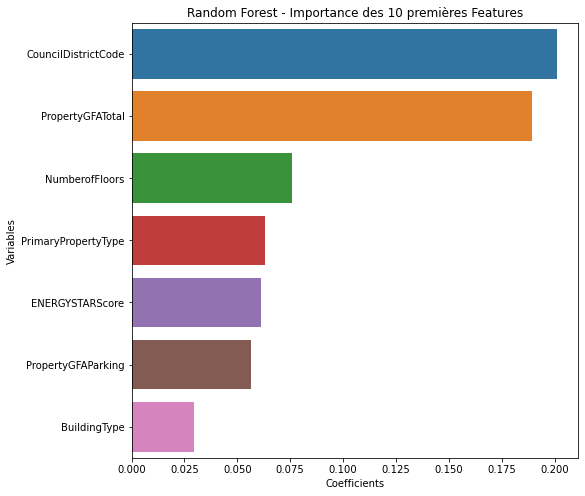

In [30]:
plt.figure(figsize=(8,8))
plt.title('Random Forest - Importance des 10 premières Features')
sns.barplot(y = liste_coefs_rer['Variables'].head(10),
            x = liste_coefs_rer['Coefficients'].head(10))
plt.show()

In [41]:
y_pred = rfr.predict(X_test)

In [42]:
# Evaluate
from sklearn.metrics import r2_score,max_error,mean_absolute_error, mean_squared_error

print("R²:", r2_score(Y_test, y_pred))
print("MAE:", mean_absolute_error(Y_test, y_pred))
print("MSE:", mean_squared_error(Y_test, y_pred))
print("RMSE:", mean_squared_error(Y_test, y_pred, squared=False))

R²: 0.3779265756331206
MAE: 96.28301898373982
MSE: 47022.23555759307
RMSE: 216.84611031234357


c:\Users\Simplon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
200 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Simplon\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Simplon\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "c:\Users\Simplon\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Simplon\anac

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

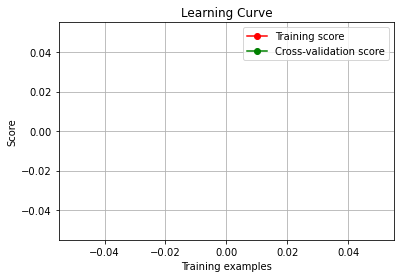

In [46]:
from scikitplot.estimators import plot_learning_curve
plot_learning_curve(rfr, X, y)

In [47]:
import pickle
rfr_model = 'rfr_model.pkl'
pickle.dump(rfr, open(rfr_model, 'wb'))